## sklearn.ensemble.BaggingClassifier

* _class_ sklearn.ensemble.BaggingClassifier(_estimator=None_, _n_estimators=10_, _*_, _max_samples=1.0_, _max_features=1.0_, _bootstrap=True_, _bootstrap_features=False_, _oob_score=False_, _warm_start=False_, _n_jobs=None_, _random_state=None_, _verbose=0_, _base_estimator='deprecated'_)[[source]](https://github.com/scikit-learn/scikit-learn/blob/364c77e04/sklearn/ensemble/_bagging.py#L544)[¶](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier "Permalink to this definition")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Warning 무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 원본 데이터에 중복된 feature명으로 인하여 신규 버전의 pandas에서 duplicate name 에러를 발생
# 중복 feature명에 대해서 원본 feature명에 '_1또는 2'를 추가로 부여하는 함수인 get_new_feature_name_df() 생성

def get_new_feature_name_df(old_feature_name_df) :
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()

    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis = 1)

    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df


def get_human_dataset() :
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를  sep으로 할당
    feature_name_df = pd.read_csv("C:/apps/ml_7/datasets/UCI HAR Dataset/UCI HAR Dataset/features.txt", sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피러명을 컬럼으로 부여하기 위해 리스트 객체로 다시 반환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피러 데이터 셋과 테스트 피처 데이터를 DataFrame으로 로딩. 컬럼명을 feature_name 적용
    X_train = pd.read_csv("C:/apps/ml_7/datasets/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt", sep='\s+', names=feature_name)
    X_test = pd.read_csv("C:/apps/ml_7/datasets/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt", sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv("C:/apps/ml_7/datasets/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv("C:/apps/ml_7/datasets/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame으 모두 반환
    return X_train, X_test, y_train, y_test

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train,X_test,y_train,y_test=get_human_dataset()

# 랜던 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf =RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy= accuracy_score(y_test,pred)
print(f"렌덤 포레스트 정확도:{accuracy:.4f}")

렌덤 포레스트 정확도:0.9253


In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


In [6]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)

print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9253


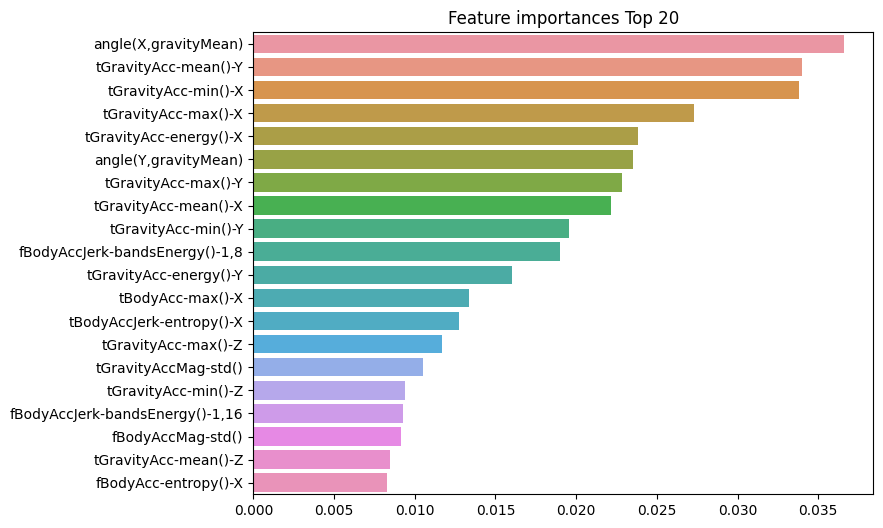

In [7]:
import seaborn as sns

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

GBM

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [9]:
X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도 : 0.9389
GBM 수행 시간 : 1486.1 초


In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100,500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv = 2, verbose=1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터 : 
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도 : 0.9002


In [11]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.9393


In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=0)
ada_clf.fit(X_train, y_train)
ada_pred = gb_clf.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_pred)

print('AdaBoost 정확도 : {0:.4f}'.format(ada_accuracy))
print('AdaBoost 수행 시간 : {0:.1f} 초'.format(time.time() - start_time))

AdaBoost 정확도 : 0.9389
AdaBoost 수행 시간 : 17543.5 초
